In [1]:
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446673 sha256=3c08dbc966aacbc83b5636eb336c1bdb2af538f07a54c53bfb7e81e837ee2fed
  

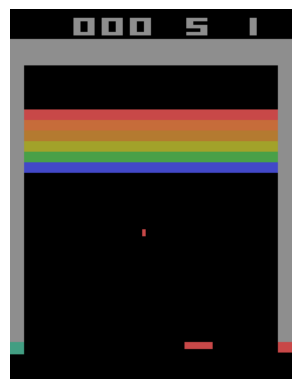

In [5]:
import gymnasium as gym
from matplotlib import pyplot as plt


env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env.reset()

action = env.action_space.sample()  # случайное действие
observation, reward, done, truncated, info = env.step(action)

image = observation

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

env.close()

In [6]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import numpy as np
import cv2
from collections import deque

class CropObservation(ObservationWrapper):
    def __init__(self, env, top=0, bottom=None, left=0, right=None):
        super().__init__(env)
        
        orig_shape = env.observation_space.shape
        orig_dtype = env.observation_space.dtype
        orig_h, orig_w = orig_shape[:2]
        c = orig_shape[2] if len(orig_shape) == 3 else 1

        self.top = max(0, top)
        self.bottom = min(orig_h, bottom) if bottom is not None else orig_h
        self.left = max(0, left)
        self.right = min(orig_w, right) if right is not None else orig_w

        assert self.top < self.bottom, "Некорректные границы: top >= bottom"
        assert self.left < self.right, "Некорректные границы: left >= right"

        self.observation_space = Box(
            low=0,
            high=255,
            shape=(self.bottom - self.top, self.right - self.left, c) if c > 1 else (self.bottom - self.top, self.right - self.left),
            dtype=orig_dtype
        )

    def observation(self, obs):
        return obs[self.top:self.bottom, self.left:self.right]

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape=(84, 84)):
        super().__init__(env)
        self.shape = shape
        self.observation_space = gym.spaces.Box(
            low=0.0, 
            high=1.0, 
            shape=shape, 
            dtype=np.float32
        )

    def observation(self, obs):
        return cv2.resize(obs, self.shape, interpolation=cv2.INTER_NEAREST)

class GrayScaleObservation(ObservationWrapper):
    def __init__(self, env, keep_dim=True):
        super().__init__(env)
        self.keep_dim = keep_dim
        channels = 1 if keep_dim else None
        shape = (*self.observation_space.shape[:2], channels) if keep_dim \
            else self.observation_space.shape[:2]
        self.observation_space = Box(
            low=0,
            high=255,
            shape=shape,
            dtype=np.uint8
        )

    def observation(self, obs):
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        return np.expand_dims(gray, axis=-1) if self.keep_dim else gray

class FrameStack(gym.Wrapper):
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shape = self.env.observation_space.shape

        if len(shape) == 3:
            h, w, c = shape
            self.observation_space = gym.spaces.Box(
                low=0, high=255,
                shape=(k, h, w),
                dtype=np.uint8
            )
        else:
            h, w = shape
            self.observation_space = gym.spaces.Box(
                low=0, high=255,
                shape=(k, h, w),
                dtype=np.uint8
            )
            
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.frames.clear()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs(), info

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, truncated, info

    def _get_obs(self):
        return np.stack(self.frames, axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(84, 84)


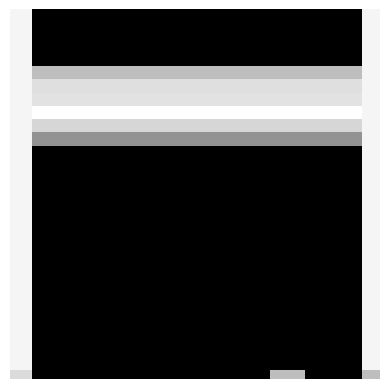

In [7]:
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env = CropObservation(env, top=34, bottom=194, left=0, right=160)
env = ResizeObservation(env, (84, 84))
env = GrayScaleObservation(env, keep_dim=False)

env.reset()
action = env.action_space.sample()
observation, reward, done, truncated, info = env.step(action)

print(observation.shape)

image = observation

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

env.close()

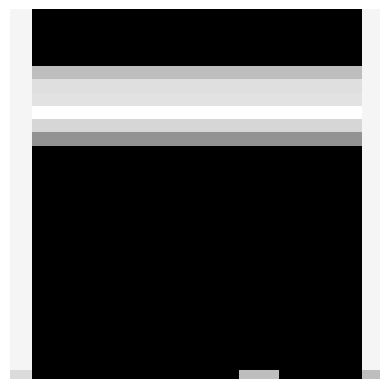

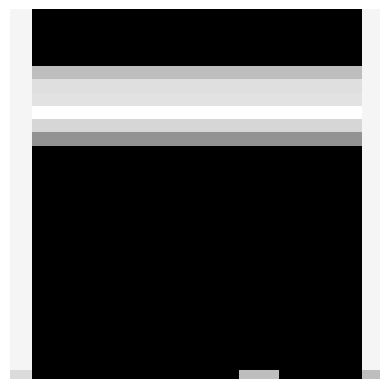

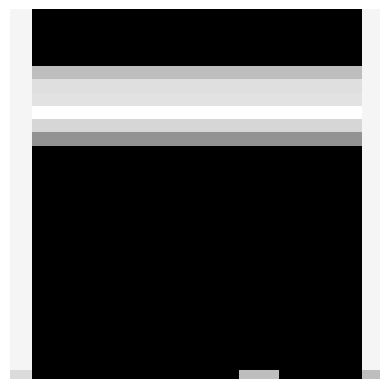

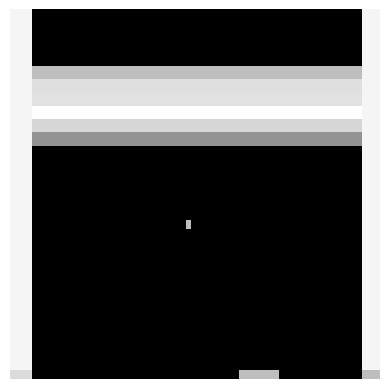

In [8]:
HEIGHT = 84
WIDTH = 84
N_STACK_FRAMES = 4

def make_env():
    env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
    env = CropObservation(env, top=34, bottom=194, left=0, right=160)
    env = ResizeObservation(env, (HEIGHT, WIDTH))
    env = GrayScaleObservation(env, keep_dim=False)
    env = FrameStack(env, N_STACK_FRAMES)
    return env

env = make_env()
env.reset()
action = env.action_space.sample()
observation, reward, done, truncated, info = env.step(action)

for frame in observation:
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.show()

env.close()


In [9]:
import torch

BATCH_SIZE = 64
LR = 0.0001
GAMMA = 0.99
MEMORY_CAPACITY = 500000
MEMORY_START_SIZE = 100000
MEMORY_START_SIZE = MEMORY_START_SIZE if MEMORY_START_SIZE > BATCH_SIZE else BATCH_SIZE
Q_NETWORK_ITERATION = 10000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
NUM_ACTIONS = env.action_space.n
Q_THRESHOLD = 30.0

In [11]:
from torch import nn, optim
import numpy as np
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_channels=N_STACK_FRAMES, num_actions=NUM_ACTIONS):
        super(Net, self).__init__()

        inner_dim = 512
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        
        self.conv.apply(self.init_weights)

        conv_out_size = self._get_conv_output((in_channels, HEIGHT, WIDTH))

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, inner_dim),
            nn.ReLU(),
            nn.Linear(inner_dim, num_actions)
        )

        self.fc.apply(self.init_weights)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def _get_conv_output(self, shape):
        dummy_input = torch.zeros(1, *shape)
        with torch.no_grad():
            conv_out = self.conv(dummy_input)
        return conv_out.numel()

    def init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)


class ExperienceReplay:
    def __init__(self, capacity):
        self.MEMORY_CAPACITY = capacity
        self.memory_counter = 0
        
        self.states = np.zeros((capacity, N_STACK_FRAMES, HEIGHT, WIDTH), dtype=np.uint8)
        self.next_states = np.zeros_like(self.states, dtype=np.uint8)
        self.actions = np.zeros((capacity,), dtype=np.int64)
        self.rewards = np.zeros((capacity,), dtype=np.float32)
        self.dones = np.zeros((capacity,), dtype=bool)

    def store_transition(self, state, action, reward, next_state, done):
        index = self.memory_counter % self.MEMORY_CAPACITY
        
        self.states[index] = state
        self.actions[index] = action
        self.rewards[index] = reward
        self.next_states[index] = next_state
        self.dones[index] = done
        
        self.memory_counter += 1

    def get_batch(self, batch_size):
        sample_index = np.random.choice(len(self), batch_size, replace=False)
        
        batch_state = torch.tensor(self.states[sample_index], dtype=torch.float32, device=DEVICE)
        batch_next_state = torch.tensor(self.next_states[sample_index], dtype=torch.float32, device=DEVICE)
        batch_action = torch.tensor(self.actions[sample_index], dtype=torch.long, device=DEVICE).unsqueeze(1)
        batch_reward = torch.tensor(self.rewards[sample_index], dtype=torch.float32, device=DEVICE).unsqueeze(1)
        batch_done = torch.tensor(self.dones[sample_index], dtype=torch.bool, device=DEVICE).unsqueeze(1)

        batch_state /= 255.0
        batch_next_state /= 255.0

        next_not_done_mask = (batch_done == 0).squeeze()

        return batch_state, batch_action, batch_reward, batch_next_state, next_not_done_mask

    def __len__(self):
        return self.memory_counter if self.memory_counter < self.MEMORY_CAPACITY else self.MEMORY_CAPACITY


class DQN:
    def __init__(self):
        super(DQN, self).__init__()
        self.possible_actions = list(range(0, NUM_ACTIONS))
        self.eval_net = Net().to(DEVICE)
        self.target_net = Net().to(DEVICE)

        self.buffer = ExperienceReplay(MEMORY_CAPACITY)

        self.learning_rate = LR
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=self.learning_rate)

    def get_action(self, state, epsilon, return_q_value=False):
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        state /= 255.0

        with torch.no_grad():
            out = self.eval_net(state)
            action = out.argmax().item()
            q_value = out.max().item() 
    
        if np.random.random() < epsilon:
            action = np.random.choice(self.possible_actions, 1)[0]
    
        if return_q_value:
            return action, q_value
        else:
            return action

    def update(self, num_steps=10):
        total_loss = 0.0
        for _ in range(num_steps):
            batch_state, batch_action, batch_reward, batch_next_state, next_not_done_mask = self.buffer.get_batch(BATCH_SIZE)

            next_not_done_states = batch_next_state[next_not_done_mask]
            next_state_values = torch.zeros(BATCH_SIZE, device=DEVICE)
            q_out = self.eval_net(batch_state)
            q_a = q_out.gather(1, batch_action)
            with torch.no_grad():
                next_state_values[next_not_done_mask] = self.target_net(next_not_done_states).max(1)[0]
            target = batch_reward + GAMMA * next_state_values.unsqueeze(1)

            loss = F.smooth_l1_loss(q_a, target.detach())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
        if num_steps == 0:
            return 0
        return total_loss / num_steps

In [8]:
import time
import os

def train(dqn: DQN, env, episodes=50000, print_every=250, save_every=2000,time_stopping=None, succ_stopping=10):
    all_rewards = []
    all_losses = []
    num_of_succeeds = 0
    steps = 0
    start_time = time.time()
         
    for n_epi in range(episodes):
        state, info = env.reset()
        ep_reward = 0
        done = False
        sum_loss = 0.0
        local_steps = 0
        
        epsilon = max(0.1, 1.0 - 0.9 * (steps / 1000000))
        
        while not done:
            local_steps += 1
            steps += 1
            action = dqn.get_action(state, epsilon)
                    
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            if done:
                next_state = np.zeros_like(state) 
                
            dqn.buffer.store_transition(state, action, reward, next_state, done)
            
            ep_reward += reward
            state = next_state

            if len(dqn.buffer) >= MEMORY_START_SIZE and steps % 4 == 0:
                loss = dqn.update(1)
                all_losses.append(loss)
                sum_loss += loss

            if steps % Q_NETWORK_ITERATION == 0:
                dqn.target_net.load_state_dict(dqn.eval_net.state_dict())
            
        avg_loss = sum_loss / local_steps  if local_steps > 0 else None
        
        if n_epi % print_every == 0:
            print(
                f"episode: {n_epi}, ",
                f"reward: {ep_reward}, ",
                f"buffer size : {len(dqn.buffer)}, ",
                f"loss: {avg_loss:.2f}, " if avg_loss is not None else "loss: N/A, ", 
                f"epsilon : {epsilon * 100:.1f}%",
                )
        
            
        all_rewards.append(ep_reward)

        if n_epi % save_every == 0:
            torch.save(dqn.target_net.state_dict(), f'target_net_{n_epi}.pt')
        if truncated:
            num_of_succeeds += 1
        if num_of_succeeds == succ_stopping:
            print(f"Succeeded {num_of_succeeds} times! Stopping...")
            break
        if time_stopping <= time.time() - start_time:
            print(f"Timelimit {time_stopping} at episode {n_epi}")
            return all_rewards, all_losses
            
    print(f"Total time: {time.time() - start_time:.2f} sec")
    return all_rewards, all_losses

episode: 0,  reward: 5.0,  buffer size : 319,  loss: 0.00,  epsilon : 100.0%
episode: 250,  reward: 1.0,  buffer size : 48181,  loss: 0.00,  epsilon : 95.7%
episode: 500,  reward: 0.0,  buffer size : 97599,  loss: 0.00,  epsilon : 91.2%
episode: 750,  reward: 4.0,  buffer size : 145657,  loss: 0.00,  epsilon : 86.9%
episode: 1000,  reward: 1.0,  buffer size : 193071,  loss: 0.00,  epsilon : 82.6%
episode: 1250,  reward: 0.0,  buffer size : 240281,  loss: 0.00,  epsilon : 78.4%
episode: 1500,  reward: 0.0,  buffer size : 288911,  loss: 0.00,  epsilon : 74.0%
episode: 1750,  reward: 0.0,  buffer size : 346469,  loss: 0.00,  epsilon : 68.8%
episode: 2000,  reward: 3.0,  buffer size : 416252,  loss: 0.00,  epsilon : 62.6%
episode: 2250,  reward: 10.0,  buffer size : 496712,  loss: 0.00,  epsilon : 55.3%
episode: 2500,  reward: 0.0,  buffer size : 500000,  loss: 0.00,  epsilon : 48.3%
episode: 2750,  reward: 7.0,  buffer size : 500000,  loss: 0.00,  epsilon : 40.7%
episode: 3000,  reward: 1

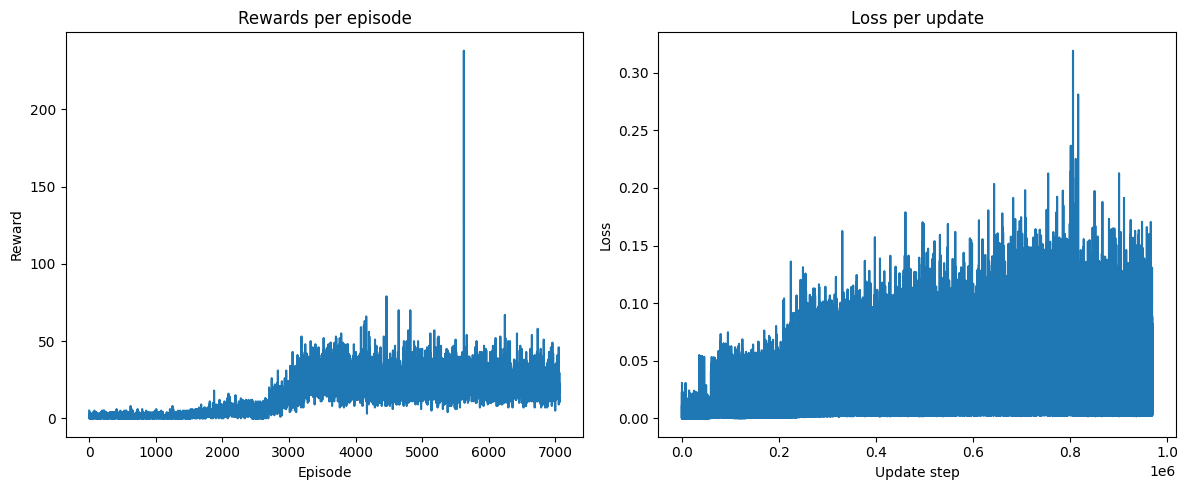

In [9]:
env = make_env()

dqn = DQN()

all_rewards, all_losses = train(dqn, env, time_stopping=25200)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Rewards per episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(all_rewards)

plt.subplot(1, 2, 2)
plt.title("Loss per update")
plt.xlabel("Update step")
plt.ylabel("Loss")
plt.plot(all_losses)


plt.tight_layout()
plt.savefig('score_loss.png')
plt.show()

In [10]:
torch.save(dqn.target_net.state_dict(), "/kaggle/working/target_last.pt")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
